In [28]:
from pathlib import Path
import pickle, collections, json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


# Introduction

This notebook explores the recorded gameplay data and try to visualise the trees.

In [60]:
DATA_DIR = Path("archive/2024-08-14T10:10:20.440481")
assert DATA_DIR.exists()
assert DATA_DIR.is_dir()

# Load the 

In [62]:
root = pickle.loads((DATA_DIR / "0000.tree.json").read_bytes())
root['action'], len(root['children']), root['value']

(1, 4, 1304.4040541984637)

In [63]:
def measure_tree(root_node: dict):
    # traverse the tree to get the number of nodes and the depth
    def traverse(node: dict | None, depth: int):
        if node is None:
            return 0, 0
        num_nodes = 1
        max_depth = depth
        for child in node['children']:
            child_nodes, child_depth = traverse(child, depth + 1)
            num_nodes += child_nodes
            max_depth = max(max_depth, child_depth)
        return num_nodes, max_depth

    return traverse(root_node, 0)

measure_tree(root)

(733, 16)

In [64]:
trees = sorted(list(DATA_DIR.glob("*.tree.json")))
print(f"Found {len(trees)} saved trees")

stats = []

for tree in trees:
    stats.append(measure_tree(pickle.loads(tree.read_bytes())))

len(stats)

Found 153 saved trees


153

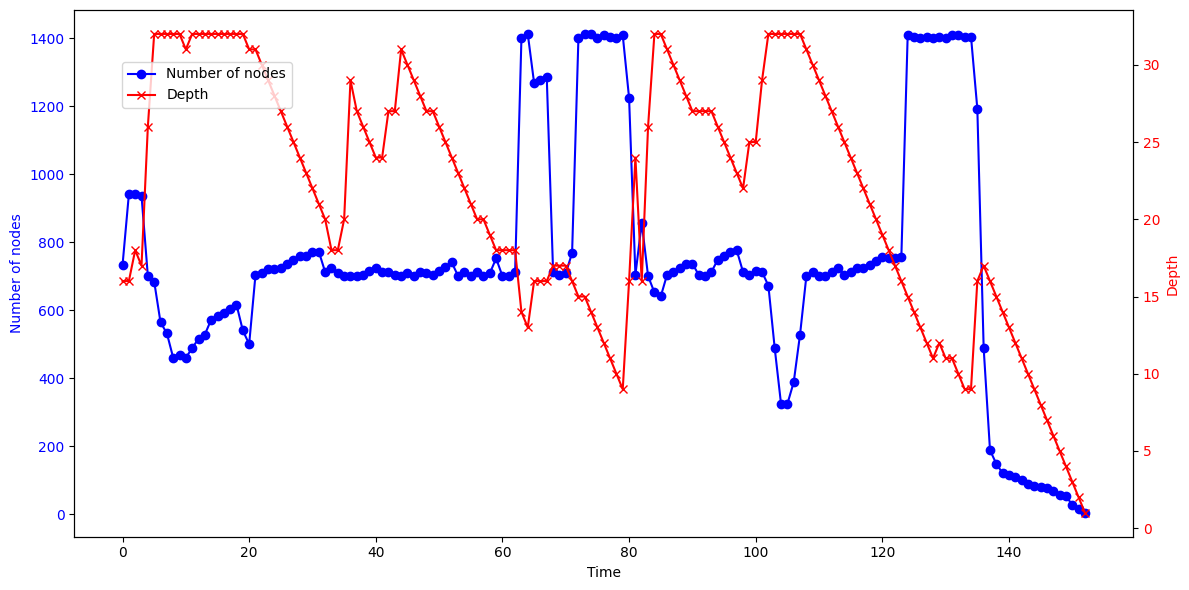

In [66]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot number of nodes on the primary y-axis
ax1.plot([s[0] for s in stats], label="Number of nodes", marker="o", color='b')
ax1.set_xlabel("Time")
ax1.set_ylabel("Number of nodes", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot([s[1] for s in stats], label="Depth", marker="x", color='r')
ax2.set_ylabel("Depth", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legend
fig.tight_layout()  # Adjust layout to make room for both y-axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

# Show the plot
plt.show()

In [44]:
# use nextworkx to visualise the tree structure
G = nx.DiGraph()

# traverse the tree to add its nodes to the graph
def add_node(node: dict | None, node_id: str, graph: nx.DiGraph):
    if node is None:
        return 0
    num_nodes = 0
    # add the node to the graph
    graph.add_node(node_id, label=node['action'], value=node['value'])
    # access its children
    for i, child in enumerate(node['children']):
        child_id = f"{node_id}-{i}"
        num_nodes += 1 + add_node(child, child_id, graph)
        graph.add_edge(node_id, child_id)
    return num_nodes

num_nodes = add_node(root, "0", G)

print(f"Created a tree with {len(G.nodes)} - {num_nodes} nodes.")

Created a tree with 29 - 28 nodes.


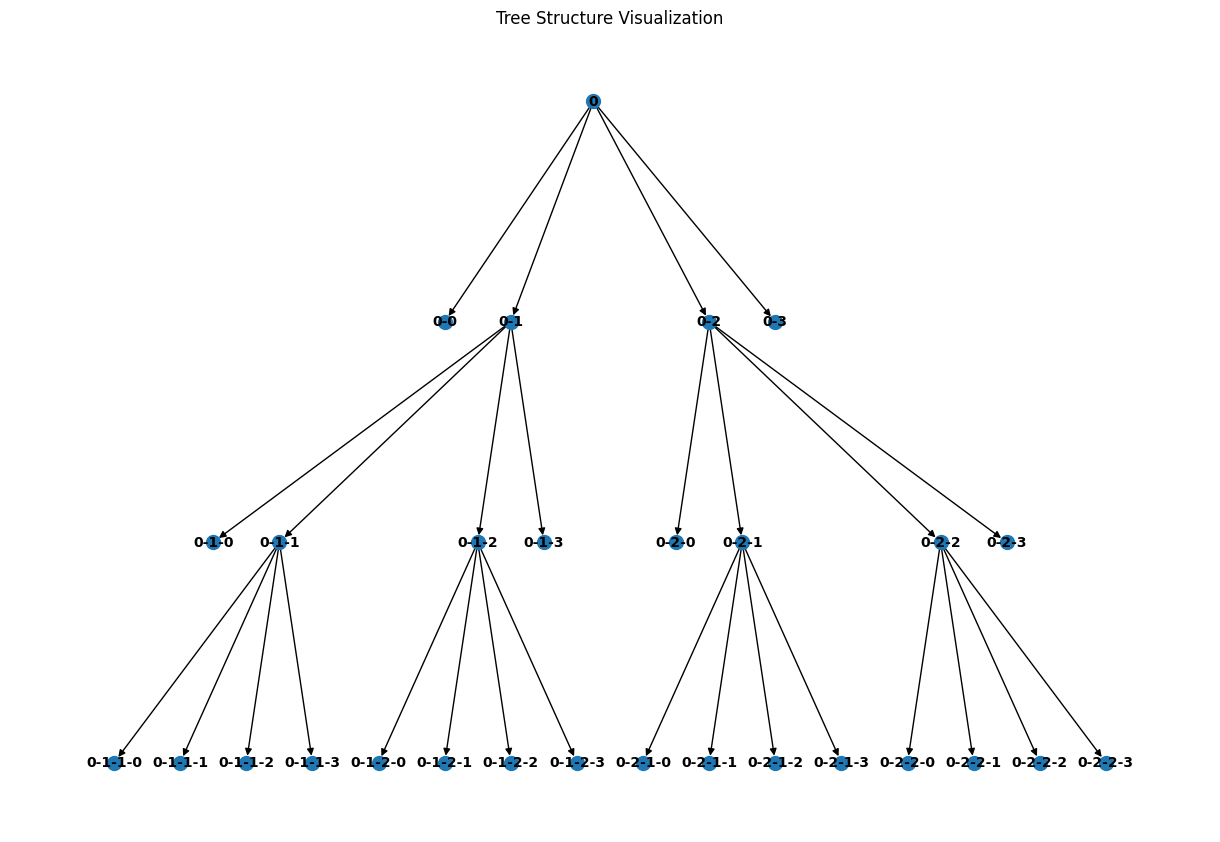

In [20]:
# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, node_size=100, font_size=10, font_weight='bold', arrows=True)

# Show the plot
plt.title("Tree Structure Visualization")
plt.show()

# Join the trees together

We load the trees for the gameplay and join them together to from a single tree.

In [47]:
trees = sorted(list(DATA_DIR.glob("*.tree.json")))
print(f"Found {len(trees)} saved trees")

graph = nx.DiGraph()
previous_root_node = "S"
previous_decision = 0

stats = []

for i, tree in enumerate(trees):
    # load the corresponding decision of the gamepplay
    decision = json.loads(tree.with_suffix("").with_suffix(".json").read_text())
    # load the tree
    tree = pickle.loads(tree.read_bytes())

    # add the tree to the graph
    root_id = f"[{i}]"
    num_nodes = add_node(tree, root_id, graph)
    graph.add_edge(previous_root_node, root_id)
    
    # save the reference of the decision node for the next tree
    previous_root_node = root_id

print("Graph size:", graph.size())

Found 150 saved trees
Graph size: 104450


In [48]:
graph.number_of_nodes()

104451

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming graph is your DiGraph
# Example: graph = nx.DiGraph()

# Use graphviz_layout with sfdp for large graphs
pos = nx.nx_agraph.graphviz_layout(graph, prog='dot', )

# Draw the graph edges only
plt.figure(figsize=(20, 20))
nx.draw_networkx_edges(graph, pos, edge_color='gray', alpha=0.5, arrows=True)

# Show the plot
plt.title("Tree Structure Visualization (Edges Only)")
plt.show()

KeyboardInterrupt: 

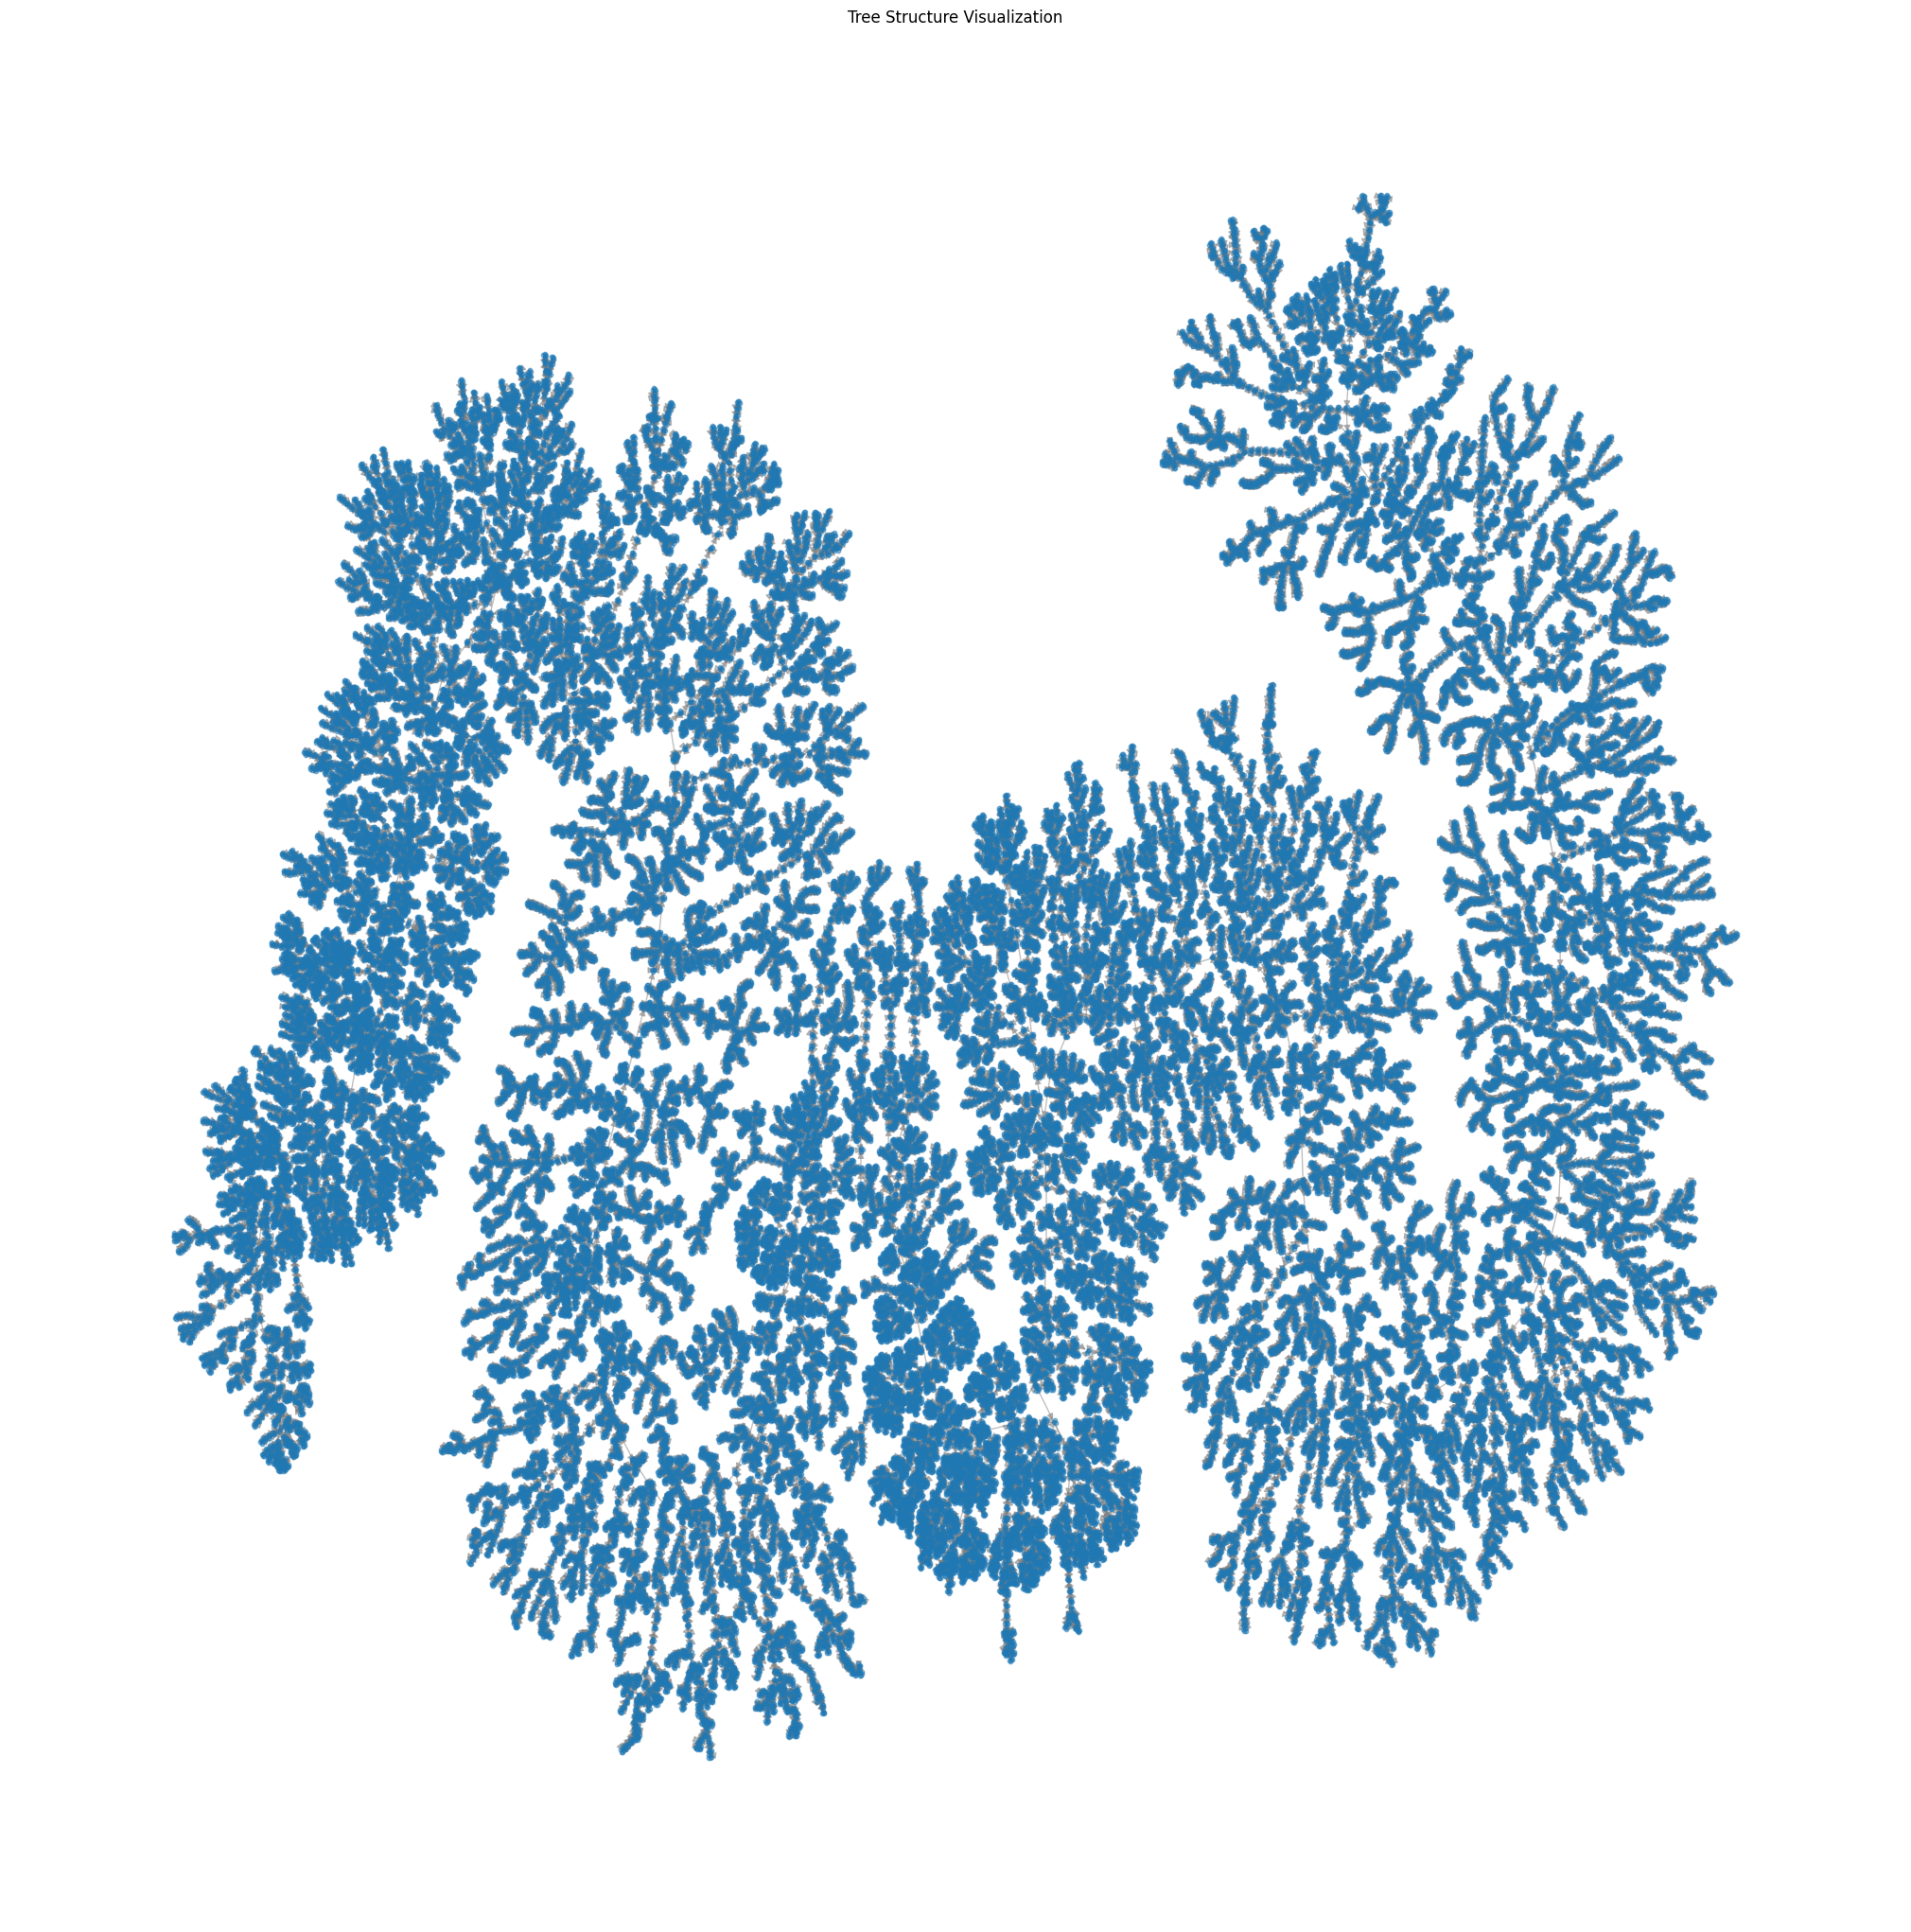

In [50]:
# Draw the graph
plt.figure(figsize=(20, 20))
pos = nx.nx_agraph.graphviz_layout(graph, prog='sfdp')
nx.draw(graph, pos, with_labels=False, node_size=10, edge_color='gray', alpha=0.5, font_size=10, font_weight='bold', arrows=True)

# Show the plot
plt.title("Tree Structure Visualization")
plt.show()